In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms


In [10]:
data_dir = 'datasets/cat_vs_dog'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(225),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(225),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=5, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=5)

In [11]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4)
trainloader

<AxesSubplot:>

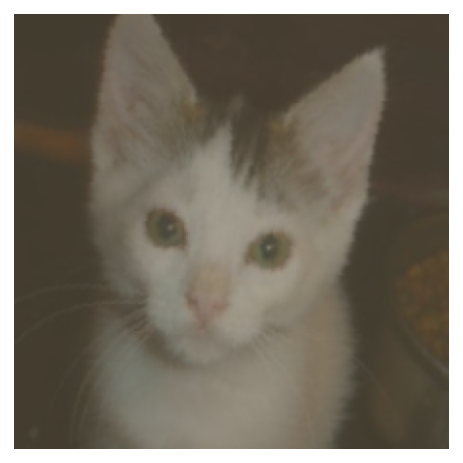

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax



# Run this to test your data loaders
images, labels = next(iter(trainloader))
imshow(images[0], normalize=True)


In [20]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim


class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.bn = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 5)
        self.fc1 = nn.Linear(16*53*53, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = self.fc2(x)
        x = F.dropout(x)
        #x = F.log_softmax(x, dim=1)
        return x





model = SmallNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device
# model.to(device)

In [21]:
from torch import optim



epochs = 4
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
                    "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                    "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                    "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

In [ ]:
import numpy as np
class_list = train_data.classes

def view_classify_general(img, ps, class_list):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    imshow(img, ax=ax1, normalize=True)
    ax1.axis('off')
    ax2.barh(np.arange(len(class_list)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(class_list)))
    ax2.set_yticklabels([x for x in class_list], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

images, labels = next(iter(trainloader))
img, label = images[0], labels[0]

# Forward pass, get our logits
logits = net(img.view(1, *images[0].shape))
# Calculate the loss with the logits and the labels
ps = torch.exp(logits)
    
view_classify_general(img, ps, class_list)